In [3]:
import mlrose_hiive
import numpy as np
import pandas as pd
import itertools
np.random.seed(44)

def getFitnessInfo(runStats):
    lastIteration = runStats[runStats.Iteration != 0].reset_index()
    fitnessMean = lastIteration.Fitness.mean()
    fitnessMax = lastIteration.Fitness.max()
    maxTime = lastIteration.Time.max()
    meanTime = lastIteration.Time.mean()
    print('fitnessMax: ', fitnessMax)
    print('fitnessMean: ', fitnessMean)
    print('maxTime: ', maxTime, 'sec')
    print('meanTime: ', meanTime, 'sec')

def plotFitness(algoValue, title, xLabel, yLabel):
    bestCurve = algoValue['bestCurve']
    ax = bestCurve.Fitness.plot(marker='.', markersize=2, figsize=(10,10), grid=1, title=title)
    ax.set_ylabel(yLabel)
    ax.set_xlabel(xLabel)
    return ax

def getBestValues(curves, algo):
    value = {}
    bestIndexCurve = curves.Fitness.idxmax()
    if(algo == "sa"):
        bestDecay = curves.iloc[bestIndexCurve].Temperature
        bestCurve = curves.loc[curves.Temperature == bestDecay, :]
    elif(algo == "rhc"):
        bestDecay = curves.iloc[bestIndexCurve].current_restart
        bestCurve = curves.loc[curves.current_restart == bestDecay, :]
        
    bestCurve.reset_index(inplace=True)
    value['bestCurve'] = bestCurve
    value['bestDecay'] = bestDecay
    return value

def getFitnessByFeatures(runStats, algo):
    lastIteration = runStats[runStats.Iteration != 0].reset_index()
    
    print("Overall Max Fitness: ", lastIteration.Fitness.max())
    print("Overall Mean Fitness: ", lastIteration.Fitness.mean())
    print("Overall Max Time: ", lastIteration.Time.max())
    print("Overall Mean Time: ", lastIteration.Time.mean())
    
    print('==========================================')
    
    if(algo == "ga"):
        mutationRateFitnessMean = lastIteration.groupby("Mutation Rate").Fitness.mean()
        populationSizeFitnessMean = lastIteration.groupby("Population Size").Fitness.mean()
        populationSizeTimeMean = lastIteration.groupby("Population Size").Time.mean() 
        print('MR      Mean Fitness:       ', mutationRateFitnessMean)

    elif(algo == "mimic"):
        keepPercentFitnessMean = lastIteration.groupby("Keep Percent").Fitness.mean()
        populationSizeFitnessMean = lastIteration.groupby("Population Size").Fitness.mean()
        populationSizeTimeMean = lastIteration.groupby("Population Size").Time.mean()
        print('keep%      Mean Fitness:       ', keepPercentFitnessMean)

    print('PS      Mean Fitness:      ', populationSizeFitnessMean)
    print('PS      Mean Time:      ', populationSizeTimeMean)

In [16]:
##5x5 grid
coordinates = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5),
              (1,2), (1,3),(1,4), (1,5),
              (2,1), (2,2), (2,3), (2,5),
              (3,3), (3,5),
              (4,0), (4,1), (4,5),
              (5,1), (5,2), (5,5)]

fitness = mlrose_hiive.TravellingSales(coords=coordinates)
travellingSalesPersonProblem = mlrose_hiive.TSPOpt(length=len(coordinates), fitness_fn=fitness)

fitnessMax:  41.4071126499133
fitnessMean:  35.31758516582213
maxTime:  642.2821088170003 sec
meanTime:  216.18762761070323 sec
CPU times: user 10min 34s, sys: 3.86 s, total: 10min 37s
Wall time: 10min 42s


<AxesSubplot:title={'center':'Fitness vs Iteration'}, xlabel='Iterations', ylabel='Fitness Value'>

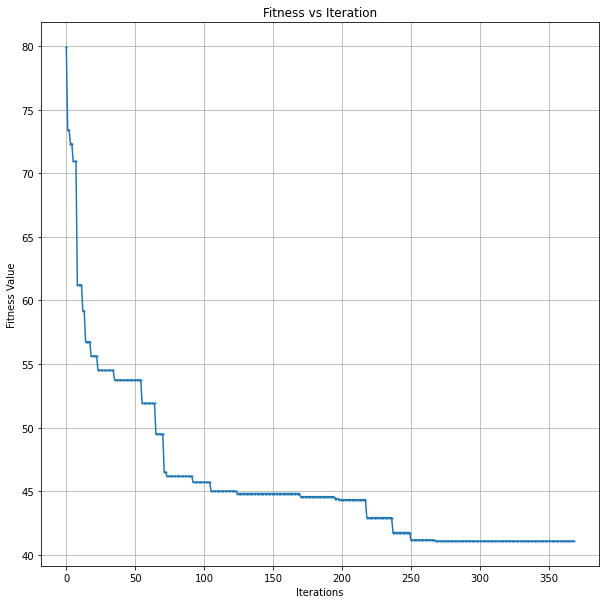

In [17]:
%%time
##Random Hill Climb
rhc = mlrose_hiive.RHCRunner(travellingSalesPersonProblem, experiment_name="RCH_final", iteration_list=[1000],
                                       seed=44, max_attempts=100, 
                                       restart_list=[100])

rhcRunStats, rhcRunCurves = rhc.run()
rhcVal = getBestValues(rhcRunCurves, 'rhc')

getFitnessInfo(rhcRunStats)
plotFitness(rhcVal, "Fitness vs Iteration","Iterations", "Fitness Value")

Best Decay {'bestCurve':       index  Iteration      Time    Fitness  FEvals Temperature  max_iters
0     11887          0  0.000292  73.766637     0.0         500       1000
1     11888          1  0.002932  75.368094     2.0         500       1000
2     11889          2  0.003225  73.019899     4.0         500       1000
3     11890          3  0.003379  74.890908     6.0         500       1000
4     11891          4  0.003519  77.392104     8.0         500       1000
...     ...        ...       ...        ...     ...         ...        ...
996   12883        996  0.147746  51.438035  1914.0         500       1000
997   12884        997  0.148168  51.438035  1915.0         500       1000
998   12885        998  0.148592  50.718833  1917.0         500       1000
999   12886        999  0.149008  53.578810  1919.0         500       1000
1000  12887       1000  0.149397  53.578810  1920.0         500       1000

[1001 rows x 7 columns], 'bestDecay': ExpDecay(init_temp=500, exp_const=0.

<AxesSubplot:title={'center':'Fitness vs Iterations (SA)'}, xlabel='Iterations', ylabel='Fitness'>

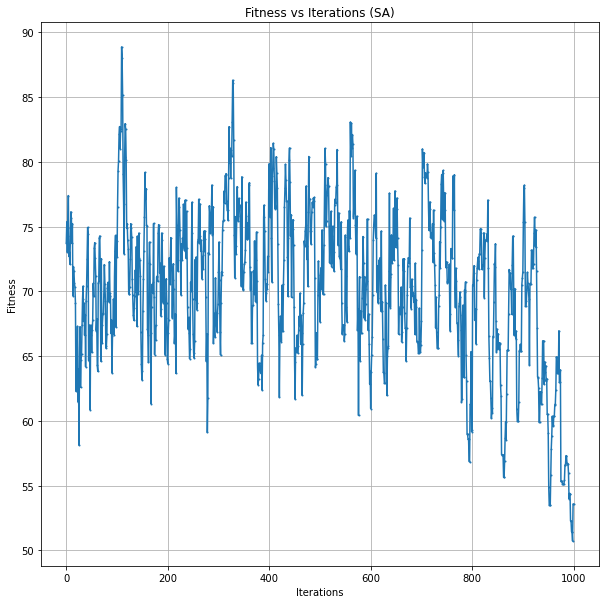

In [22]:
%%time
##Simulated Annealing
sa = mlrose_hiive.SARunner(travellingSalesPersonProblem, experiment_name="SA_final", iteration_list=[1000],
                           temperature_list=[1, 10, 25, 50, 100, 200, 500, 1000], decay_list=[mlrose_hiive.GeomDecay, mlrose_hiive.ExpDecay], seed=44, max_attempts=100)

saRunStats, saRunCurves = sa.run()
saVal = getBestValues(saRunCurves, 'sa')
print("Best Decay", saVal)

getFitnessInfo(saRunStats)
plotFitness(saVal, 'Fitness vs Iterations (SA)', 'Iterations', 'Fitness')

In [19]:
%%time
##Genetic Algorithm
ga = mlrose_hiive.GARunner(travellingSalesPersonProblem, experiment_name='GA_final', iteration_list=[1000], 
                           population_sizes=[100, 500, 1000], mutation_rates=[0.1, 0.25, 0.5, 0.9], 
                           seed=44, max_attempts=100)

gaRunStats, gaRunCurves = ga.run()
getFitnessByFeatures(gaRunStats, 'ga')

Overall Max Fitness:  30.556395895082645
Overall Mean Fitness:  28.627225405178592
Overall Max Time:  42.534008955999525
Overall Mean Time:  16.9774074979166
MR      Mean Fitness:        Mutation Rate
0.10    28.833540
0.25    28.872385
0.50    28.385841
0.90    28.417136
Name: Fitness, dtype: float64
PS      Mean Fitness:       Population Size
100     29.080619
500     29.500494
1000    27.300563
Name: Fitness, dtype: float64
PS      Mean Time:       Population Size
100      3.904095
500     15.977094
1000    31.051034
Name: Time, dtype: float64
CPU times: user 3min 21s, sys: 1.11 s, total: 3min 22s
Wall time: 3min 23s


In [20]:
%%time
##Mimic Algorithm
mimic = mlrose_hiive.MIMICRunner(travellingSalesPersonProblem, experiment_name='MIMIC_final', iteration_list=[1000], use_fast_mimic=True,
                                population_sizes=[100,500], keep_percent_list=[0.1, 0.25, 0.5, 0.9],
                                seed=44, max_attempts=100)

mimicRunStats, mimicRunCurves = mimic.run()
getFitnessByFeatures(mimicRunStats, 'mimic')

Overall Max Fitness:  56.894303271541894
Overall Mean Fitness:  47.535108563197724
Overall Max Time:  85.73781952899935
Overall Mean Time:  47.70030259837483
keep%      Mean Fitness:        Keep Percent
0.10    50.191648
0.25    47.530788
0.50    43.690693
0.90    48.727306
Name: Fitness, dtype: float64
PS      Mean Fitness:       Population Size
100    52.937348
500    42.132869
Name: Fitness, dtype: float64
PS      Mean Time:       Population Size
100    17.071059
500    78.329546
Name: Time, dtype: float64
CPU times: user 6min 15s, sys: 3.92 s, total: 6min 19s
Wall time: 6min 21s
